# Neural Networks Assignment. 
The first cell imports all the modules required for the network to train and show results. It also contains the necessary functions. It is a modified version of the myutils package provided during the module. 

An additional print version of the train and test function is added, which is slightly quicker than the graph version. This was used in the parameter tuning phase. It stops training when the train and test accuracies strayed more than 5%. You will see the use of this in the later cells, with the graph display version following. 
The graph-displaying training function and linked functions are modified to show increased y limits and more y grid lines for easier viewing.

In [1]:
import torch
from torch import nn
from IPython import display
import numpy as np
import torchvision
from torchvision import transforms
from torch import nn
from torch.nn import functional as F
from torch.utils import data
import torch.optim as optim
import matplotlib.pyplot as plt
import collections
import math
import re
import sys
import time
d2l = sys.modules[__name__]

def get_dataloader_workers():
    """Use 4 processes to read the data."""
    return 4

def load_data_fashion_mnist(batch_size, resize=None):
    """Download the Fashion-MNIST dataset and then load it into memory."""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

argmax = lambda x, *args, **kwargs: x.argmax(*args, **kwargs)
astype = lambda x, *args, **kwargs: x.type(*args, **kwargs)
reduce_sum = lambda x, *args, **kwargs: x.sum(*args, **kwargs)
size = lambda x, *args, **kwargs: x.numel(*args, **kwargs)


def accuracy(y_hat, y): 
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = d2l.argmax(y_hat, axis=1)        
    cmp = d2l.astype(y_hat, y.dtype) == y
    return float(d2l.reduce_sum(d2l.astype(cmp, y.dtype)))

def evaluate_accuracy(net, data_iter): 
    """Compute the accuracy for a model on a dataset."""
    if isinstance(net, torch.nn.Module):
        net.eval()  # Set the model to evaluation mode
    metric = Accumulator(2)  # No. of correct predictions, no. of predictions
    for _, (X, y) in enumerate(data_iter):
        metric.add(accuracy(net(X), y), d2l.size(y))
    return metric[0] / metric[1]

class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


def training_loop(net, train_iter, loss, updater): 
    # Set the model to training mode
    if isinstance(net, torch.nn.Module):
        net.train()
    # Sum of training loss, sum of training accuracy, no. of examples
    metric = Accumulator(3)
    for X, y in train_iter:
        # Compute gradients and update parameters
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(float(l) * len(y), accuracy(y_hat, y),
                       y.size().numel())
        else:
            l.sum().backward()
            updater(X.shape[0])
            metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]


def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    axes.set_yticks([0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,
                     0.85,0.9,0.95,1]) #show more y gridlines
    if legend:
        axes.legend(legend, bbox_to_anchor=(1.3, 1)) #position changed
    axes.grid()
    
def use_svg_display():
    """Use the svg format to display a plot in Jupyter."""
    display.set_matplotlib_formats('svg')


class Animator:
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(7, 5)): #edited
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)


def train_graph(net, train_iter, test_iter, loss, num_epochs, updater):
    """Train a model and display a graph."""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                        legend=['Train loss', 'Train acc', 'Test acc'])
    for epoch in range(num_epochs):
        train_metrics = training_loop(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
        scheduler.step()
    train_loss, train_acc = train_metrics
    
def train_prints(net, train_iter, test_iter, loss, num_epochs, updater):
    """Train a model and display print statements"""
    print("Train and test sequence started")
    start = time.time()
    current_loss = 0.2
    for epoch in range(num_epochs):
        previous_loss = current_loss
        train_metrics = training_loop(net, train_iter, loss, updater)
        current_loss, train_acc = train_metrics
        test_acc = evaluate_accuracy(net, test_iter)
        current_acc = test_acc
        difference = math.fabs(train_acc - test_acc)
        if epoch > 5:
            if difference > 0.05: # stops epoch iteration if train accuracy much more than test
                print("Overfitting!!!")
                break
        print("Test Accuracy epoch {}: {} | Training Loss: {}".format(epoch, current_acc, current_loss))
        """ The following is for time estimation """
        if epoch != 0: 
            if epoch % 5 == 0: # only calculates time left every 5 epochs
                end = time.time()
                est = (end - start)*(num_epochs-epoch)/epoch
                minutes = est//60
                seconds = est % 60
                print("\nEstimated time left: " + str(minutes) + "m " 
                      + str(round(seconds)) + "s | "
                      + str(num_epochs - epoch - 2) + " epochs to go\n")
        scheduler.step()
    train_loss, train_acc = train_metrics
    print("Final test accuracy: {} | Final train loss: {}".format(current_acc, train_loss))

def evaluate_loss(net, data_iter, loss):
    """Evaluate the loss of a model on the given dataset."""
    metric = d2l.Accumulator(2)  # Sum of losses, no. of examples
    for X, y in data_iter:
        l = loss(net(X), y)
        metric.add(d2l.reduce_sum(l), d2l.size(l))
    return metric[0] / metric[1]

C:\ProgramData\Anaconda3\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\ProgramData\Anaconda3\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


## 1. Loading Data

In [2]:
train_iter, test_iter = load_data_fashion_mnist(256)

### Proposed Patch Splitting
Tested viewing of patches via unfold method

(-0.5, 13.5, 13.5, -0.5)

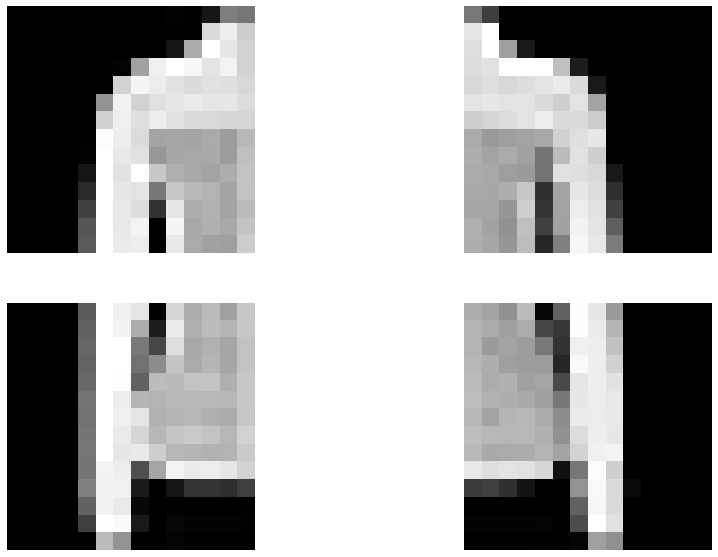

In [3]:
X, y = next(iter(train_iter))
unfold = nn.Unfold(kernel_size=(14,14), stride=14)
unfolded = unfold(X)
# unfolded.shape

test = unfolded[1].transpose(0,1) # only required for viewing
# test.shape

fig, ((a1,a2),(a3,a4)) = plt.subplots(2,2, figsize=(15,10)) # test if new dataset is correct #, dpi=600
a1.imshow(test[0].view(14,14), cmap="gray")
a1.axis("off")
a2.imshow(test[1].view(14,14), cmap="gray")
a2.axis("off")
a3.imshow(test[2].view(14,14), cmap="gray")
a3.axis("off")
a4.imshow(test[3].view(14,14), cmap="gray")
a4.axis("off")

## 2. Creating the network architecture
Trial and error of the network architecture lead to an optimum of 2 blocks. Other features like batch normalisation and drop-out layers were attempted but reduced accuracy. (More detail in supplementary PDF)

In [12]:
class Net(torch.nn.Module):
    def __init__(self, num_inputs, num_hidden1, num_hidden2, num_hidden3, num_hidden4, num_hidden5, 
                 num_hidden6, num_hidden7, num_hidden8, num_hidden9, num_mean, num_out):
        super(Net, self).__init__()
        self.unfold = nn.Unfold(kernel_size=(7,7), stride=7) # gets every 7*7 block
        self.relu = nn.ReLU()
        self.Linear1 = nn.Linear(num_inputs, num_hidden1)
        self.Linear2 = nn.Linear(num_hidden1, num_hidden2)
        self.Linear3 = nn.Linear(num_hidden2, num_hidden3)
        self.Linear4 = nn.Linear(num_hidden3, num_hidden4)
        self.Linear5 = nn.Linear(num_hidden4, num_hidden5)
        self.Linear6 = nn.Linear(num_hidden5, num_hidden6)
        self.Linear7 = nn.Linear(num_hidden6, num_hidden7)
        self.Linear8 = nn.Linear(num_hidden7, num_hidden8)
        self.Linear9 = nn.Linear(num_hidden8, num_mean)
        self.last = nn.Linear(num_mean, num_out)
        
    def forward(self, x):     
        
        # Stem:
        # print(x.shape)
        x = self.unfold(x) # splits into patches of 7*7 * 16 dimensions
        x = self.Linear1(x)
        
        # Backbone
        # Block 1 
        # MLP 1
        x = torch.transpose(x, 1, 2) # swaps patch number with number of pixels
        x = self.Linear2(x) # XTW1
        x = self.relu(x) # g(XTW1)
        x = self.Linear3(x) #g(XTW1)W2
        
        # MLP 2
        x = torch.transpose(x, 1, 2) #OT
        x = self.Linear4(x) #O1W3
        x = self.relu(x) #g(O1W3)
        x = self.Linear5(x) #g(O1W3)W4
        
        # Block 2 
        # MLP 1
        x = torch.transpose(x, 1, 2) # swaps patch number with number of pixels
        x = self.Linear6(x)
        x = self.relu(x)
        x = self.Linear7(x)
        
        # MLP 2
        x = torch.transpose(x, 1, 2)
        x = self.Linear8(x)
        x = self.relu(x)
        x = self.Linear9(x)
        
        # Classifier
        # Mean Feature
        x = torch.mean(x, 1)
        
        #Final Classifier
        x = self.last(x)
        return x

## Net Initialisation
The first input is 16 because each image has 16 patches. From trial and error, the hidden layers inputs and outputs at 49 seem to have the best performance. The last final linear layer has 10 outputs, equal to the number of classes.

In [17]:
num_inputs, num_hidden1, num_hidden2, num_hidden3, num_hidden4 = 16, 49, 49, 49, 49
num_hidden5, num_hidden6 = 49, 49
num_hidden7, num_hidden8, num_hidden9 = 49, 49, 49
num_mean, num_out = 49, 10

net = Net(num_inputs, num_hidden1, num_hidden2, num_hidden3, num_hidden4, num_hidden5, 
          num_hidden6, num_hidden7, num_hidden8, num_hidden9, num_mean, num_out)

## 3. Loss, Optimiser, Weights

A scheduler object is created in this cell with step size of 5, because, in parameter tuning, I found that after around 5 epochs the test accuracy did not increase much. Therefore, it is important to reduce the learning rate to avoid missing the optimum. I chose a gamma of 0.5 arbitrarily as 'half-life' is commonly used in many parts of the scientific world.

In [18]:
loss = nn.CrossEntropyLoss()
lr = 0.002 # lr is low because otherwise accuracy volatile
optimizer = torch.optim.Adam(net.parameters(), lr=lr) # Adam converges faster
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

Weights initialised via kaiming method, as this is more stable which avoids vanishing or exploding gradients.

In [19]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight)
        torch.nn.init.zeros_(m.bias)

net.apply(init_weights)

Net(
  (unfold): Unfold(kernel_size=(7, 7), dilation=1, padding=0, stride=7)
  (relu): ReLU()
  (Linear1): Linear(in_features=16, out_features=49, bias=True)
  (Linear2): Linear(in_features=49, out_features=49, bias=True)
  (Linear3): Linear(in_features=49, out_features=49, bias=True)
  (Linear4): Linear(in_features=49, out_features=49, bias=True)
  (Linear5): Linear(in_features=49, out_features=49, bias=True)
  (Linear6): Linear(in_features=49, out_features=49, bias=True)
  (Linear7): Linear(in_features=49, out_features=49, bias=True)
  (Linear8): Linear(in_features=49, out_features=49, bias=True)
  (Linear9): Linear(in_features=49, out_features=49, bias=True)
  (last): Linear(in_features=49, out_features=10, bias=True)
)

## Parameter Tuning
The cell following was used to tune parameters. The next cell shows the loss/accuracy curve. In the interest of time, it was stopped once the test and train accuracy strayed more than five percent. The final model accuracy can be shown in a print out here.

Weights and scheduler are both reinitialised after every parameter change.

In [16]:
num_epochs = 60
train_prints(net, train_iter, test_iter, loss, num_epochs, optimizer) # testing function for trial and error

Train and test sequence started
Test Accuracy epoch 0: 0.8292 | Training Loss: 0.726997774887085
Test Accuracy epoch 1: 0.8375 | Training Loss: 0.43166610210736595
Test Accuracy epoch 2: 0.843 | Training Loss: 0.39394688340822853
Test Accuracy epoch 3: 0.8558 | Training Loss: 0.3717569183190664
Test Accuracy epoch 4: 0.86 | Training Loss: 0.3457586508909861
Test Accuracy epoch 5: 0.8639 | Training Loss: 0.3130196358203888

Estimated time left: 17.0m 34s | 53 epochs to go

Test Accuracy epoch 6: 0.8704 | Training Loss: 0.3040029721895854
Test Accuracy epoch 7: 0.8644 | Training Loss: 0.2939513436794281
Test Accuracy epoch 8: 0.8703 | Training Loss: 0.2898995328585307
Test Accuracy epoch 9: 0.8744 | Training Loss: 0.28110516861279805
Test Accuracy epoch 10: 0.8703 | Training Loss: 0.2635167640844981

Estimated time left: 14.0m 16s | 48 epochs to go

Test Accuracy epoch 11: 0.8722 | Training Loss: 0.25737016474405927
Test Accuracy epoch 12: 0.8745 | Training Loss: 0.2539172564188639
Test 

## 4. Training Loss, Accuracy and Test Accuracy Curve
The following cell shows the final model's loss and accuracy curve. As shown in the printouts above, no significant change in accuracy is observed past 20 epochs, however, 60 are shown below to show the extent of overfitting if allowed to continue.

The curve shows that the test accuracy settles above 0.85. You can see that the learning rate reduction scheduler is working, as the accuracy lines become straighter after many epochs, showing less variance.

The weights and scheduler were re-initialised before running this cell.

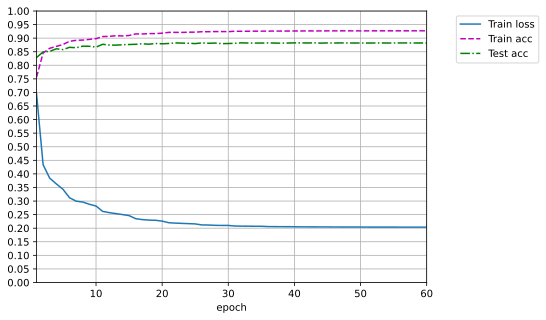

In [20]:
train_graph(net, train_iter, test_iter, loss, num_epochs, optimizer) #reinitialise weights before running

## 5. Final Model Accuracy

In [21]:
print("Final accuracy is {}".format(evaluate_accuracy(net, test_iter)))

Final accuracy is 0.8822


## Hyperparameters Used
* Initial learning rate of optimiser: 0.002
* Step size of scheduler: 5 epochs
* Gamma of scheduler = 0.5
* Hidden layer output features = 49
* Epochs to display on graph = 60 (overfitting any further)